# Импорт библиотек

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms

from collections import Counter
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

from scipy.signal import savgol_filter

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

from tslearn.clustering import TimeSeriesKMeans

from random import randint

/var/folders/gn/6xkn0qgj31j3r_95lg2kqbv00000gn/T/ipykernel_2960/310177463.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(42)

# Загрузка данных и их подготовка

In [4]:
path_ir = 'data/ftir'

path_to_curves = os.listdir(path_ir)
path_to_curves = sorted(path_to_curves, key=lambda x: int(x.split('.')[0]))
path_to_curves = [path_ir + '/' + filename for filename in path_to_curves]

ir_id = {}

for i, p in enumerate(path_to_curves):
    name = p.split('/')[-1].split('.')[0]
    ir_id[i] = name

In [5]:
def extract_ir_data(path):
    with open(path, 'r') as f:
        data = f.readlines()
        x_lst, y_lst = [], []
        for line in data:
            line = line.rstrip()
            x, y = map(float, line.split(','))
            x_lst.append(x)
            y_lst.append(y)
    return x_lst, y_lst

In [6]:
full_X = extract_ir_data(path_to_curves[0])[0]
X = list(filter(lambda x: x >= 800, full_X))

In [7]:
Y = [extract_ir_data(p)[1][:len(X)] for p in path_to_curves]  # initial

Y_smooth_only = [savgol_filter(y, window_length=53, polyorder=3) for y in Y]  # smoothed

scaler = MinMaxScaler()
Y_smooth = list(scaler.fit_transform(np.array(Y_smooth_only).T).T)  # smoothed and normalized to [0...1]

In [8]:
Y_torch = torch.Tensor([Y_smooth])
Y_torch.shape

torch.Size([1, 26, 1142])

In [9]:
Y_torch = Y_torch.permute(1, 0, 2)
Y_torch.shape

torch.Size([26, 1, 1142])

In [10]:
full_description = ['MFGO, разб. 1:20',
                    'HGO, 0.0116 г в 25 мл H2O',
                    'GO, RusGraphene, 2 г в 1000 мл H2O',
                    'rGO, 2 г в 1000 мл H2O',
                    'rGO, RusGraphene, 2 г в 1000 мл H2O',
                    'GO, RusGraphene, 2 г в 1000 мл H2O',
                    'GO, RusGraphene, 1.00 г в 250 мл H2O',
                    'rGO, RusGraphene, 0.20 г в 100 мл H2O',
                    'GO, RusGraphene, 1.00 г в 250 мл H2O',
                    'GO, USA, 0.1 г в 100 мл H2O',
                    'GO, RusGraphene, 2 г в 1000 мл H2O',
                    'Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня',
                    'Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня',
                    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в H2O',
                    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М',
                    'Образец 10 после диализа 3.5 кДа, конд.',
                    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М (повторное использование)',
                    'Образец 9 после диализа 14 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М (повторное использование)',
                    'Образец 11 после диализа 2 дня, H2O, 1 кДа',
                    'Образец 11 после диализа 5 дней, H2O, 14 кДа 75 мм',
                    'Образец 9 после диализа при 25°С 14 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 9 после диализа при 45°С 14 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 13 после диализа 0.5 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 30 после диализа 12 дней, 14 кДа, конд. 7 дней в ЭДТА 0.05М']

short_description = ['$GO$',
                     '$GO$',
                     '$GO$',
                     '$rGO$',
                     '$rGO$',
                     '$GO$',
                     '$GO$',
                     '$rGO$',
                     '$GO$',
                     '$GO$',
                     '$GO$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$rGO$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$']

class_lst = [0 if el == '$rGO$' else 1 if el == '$GO$' else 2 for el in short_description]

# Аугментация данных для обучения

In [144]:
%%time

aug_factor = 200
min_sigma = 5e-4
max_sigma = 1e-2

# спектры
Y_smooth_aug = Y_smooth.copy()
for y in Y_smooth:
    st_dev_values = np.linspace(min_sigma, max_sigma, aug_factor)
    for st_dev in st_dev_values:
        new_y = y + np.random.normal(0, st_dev, len(y))
        Y_smooth_aug += [new_y]

# описание
full_description = [] + short_description
for descr in short_description:
    full_description += [descr] * aug_factor

# класс
full_class = [] + class_lst
for class_ in class_lst:
    full_class += [class_] * aug_factor

# датасет с аугментированными данными
Y_aug_df = pd.DataFrame(Y_smooth_aug)
Y_aug_df.insert(loc=0, column='$Class$', value=full_class)
Y_aug_df.insert(loc=1, column='$Type$', value=full_description)

# скалирование спектров
scaler = MinMaxScaler()
Y_aug_df.iloc[:, 2:] = scaler.fit_transform(Y_aug_df.iloc[:, 2:].T).T

Y_aug_df.sample(5)

CPU times: user 2.27 s, sys: 277 ms, total: 2.55 s
Wall time: 2.57 s


,$Class$,$Type$,0,1,2,3,4,5,6,7,...,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
2791,2,$GO_{d}$,0.026024,0.011246,0.021435,0.022597,0.017966,0.011929,0.027432,0.006652,...,0.055018,0.052285,0.040760,0.055691,0.040291,0.059147,0.050943,0.055835,0.049510,0.057479
3818,2,$GO_{d}$,0.019174,0.022739,0.040374,0.024648,0.018360,0.000000,0.027719,0.021207,...,0.097928,0.108845,0.101937,0.093440,0.095895,0.080091,0.094425,0.085979,0.093029,0.098182
145,1,$GO$,0.011770,0.015463,0.016229,0.020004,0.013547,0.012446,0.000000,0.014256,...,0.023087,0.021306,0.031926,0.031125,0.029487,0.025911,0.028679,0.018035,0.022269,0.026389
3661,2,$GO_{d}$,0.007420,0.008887,0.006932,0.005227,0.007959,0.004612,0.009622,0.002759,...,0.081146,0.081883,0.080063,0.079955,0.079430,0.074897,0.084484,0.086751,0.082437,0.077806
2336,2,$GO_{d}$,0.011020,0.016947,0.022706,0.019766,0.024907,0.010108,0.007422,0.015051,...,0.040094,0.044889,0.053593,0.049011,0.042742,0.046007,0.032070,0.040834,0.041841,0.040893


# Подготовка dataloader'а

## Разбиение датасета со стратификацией

In [145]:
X_spectra = Y_aug_df.iloc[:, 2:]
y = Y_aug_df['$Class$']

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_spectra, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)

## Создание $torch$-тензора и $torch$-датасета

In [147]:
X_train_torch = torch.Tensor([np.array(X_train.iloc[:, :])])
X_test_torch = torch.Tensor([np.array(X_test.iloc[:, :])])

print(X_train_torch.shape, X_test_torch.shape, sep='\n')

torch.Size([1, 3919, 1142])
torch.Size([1, 1307, 1142])


In [148]:
X_train_torch = X_train_torch.permute(1, 0, 2)
X_test_torch = X_test_torch.permute(1, 0, 2)

print(X_train_torch.shape, X_test_torch.shape, sep='\n')

torch.Size([3919, 1, 1142])
torch.Size([1307, 1, 1142])


In [149]:
# arguments = (X, y) = (X, X) in our case

dataset_train = TensorDataset(X_train_torch, X_train_torch)
dataset_test = TensorDataset(X_test_torch, X_test_torch)

## Создание dataloader'a

In [150]:
train_size = 0.8
val_size = 1 - train_size

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=False)

# Построение модели и ее обучение

In [151]:
path_to_save = 'results/ftir/step3'

## Функция для обучения

In [152]:
outputs = []

def train(model,
          train_loader,
          val_loader,
          loss_function,
          optimizer,
          plot_every_n_epoch=50,
          n_epochs=100,
          stop_criteria=None,
          path_to_save=None):
    epochs = []
    losses_train = []
    losses_val = []
        
    for epoch in range(1, n_epochs+1):
        
        # обучение на тренировочном датасете    
        model.train()

        loss_train_lst = []
        for i, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            reconstructed, _ = model(x_batch)
            loss = loss_function(reconstructed, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train_lst.append(loss.item())
            
        avg_loss = np.mean(loss_train_lst)
        losses_train.append(avg_loss)
        
        # тестирование на валидационном датасете
        model.eval()
        
        loss_val_lst = []
        for i, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            reconstructed, _ = model(x_batch)
            loss = loss_function(reconstructed, y_batch)
            loss_val_lst.append(loss.item())
        
        avg_loss = np.mean(loss_val_lst)
        losses_val.append(avg_loss)
            
        epochs.append(epoch)
        
        if epoch % plot_every_n_epoch == 0:   
            clear_output(True)

            fig = plt.figure(figsize=(14, 5), dpi=150, linewidth=1.0)
            
            # 1 окно
            plt.subplot(1, 2, 1)
            plt.grid(True)
            plt.tick_params(direction='in')
            ax = fig.gca()
            
            ax.scatter(epochs,
                       losses_train,
                       marker='s',
                       color='blue',
                       edgecolor='black',
                       alpha=0.6,
                       label='$train$ $set$')
            
            ax.scatter(epochs,
                       losses_val,
                       marker='s',
                       color='orange',
                       edgecolor='black',
                       alpha=0.6,
                       label='$validation$ $set$')
            
            ax.set_xlabel('Number of epoch', fontname='DejaVu Sans', fontstyle='italic', fontsize=14)
            ax.set_ylabel('$MSE_{average}$', fontname='DejaVu Sans', fontsize=14, rotation=90, labelpad=15)
            
            ax.legend(
#                 title='Average MSE',
                fancybox=True,
                shadow=True,
                prop={'size': 10}).get_title().set_fontsize('12')
            
            # 2 окно
            plt.subplot(1, 2, 2)
            plt.grid(True)
            plt.tick_params(direction='in')
            ax = fig.gca()
            
            model.eval()
            
            for batch in val_loader:
                x_batch = batch[0]
                
                batch_index = randint(0, x_batch.shape[0]-1)
                real_target_numpy = x_batch.detach().numpy()[batch_index][0]
                break
                
            reconstructed_by_model = model(x_batch)[0][batch_index][0].detach().numpy()
            
            ax.plot(X,
                    real_target_numpy,
                    linestyle='-',
                    color='green',
                    linewidth=2.5,
                    label='$before$ $autoencoder$'
                    )
            
            ax.plot(X,
                    reconstructed_by_model,
                    linestyle='-',
                    color='red',
                    linewidth=1.5,
                    label='$after$ $autoencoder$'
                    )
            
            ax.set_xlabel('$λ^{-1}, cm^{-1}$', fontname='DejaVu Sans', fontsize=14)
            ax.set_ylabel('$A_{n}$', fontname='DejaVu Sans', fontsize=14, rotation=0, labelpad=15)
                        
            plt.gca().invert_xaxis()
            
            ax.legend(title='Spectrum',
                      fancybox=True,
                      shadow=True,
                      prop={'size': 10}).get_title().set_fontsize('12')
            
            if epoch == n_epochs:
                if path_to_save:
                    plt.savefig(path_to_save, dpi=600)
            
            plt.show()
        
        if stop_criteria:
            if len(losses_val) > 10:
                if abs(losses_val[-1] - losses_val[-10]) <= stop_criteria:
                    break

## Модель на основе линейных слоев

### Архитектура

In [153]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1142, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 512),
            nn.Sigmoid(),
            nn.Linear(512, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 1142),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

### Обучение

In [154]:
autoencoder = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-5)

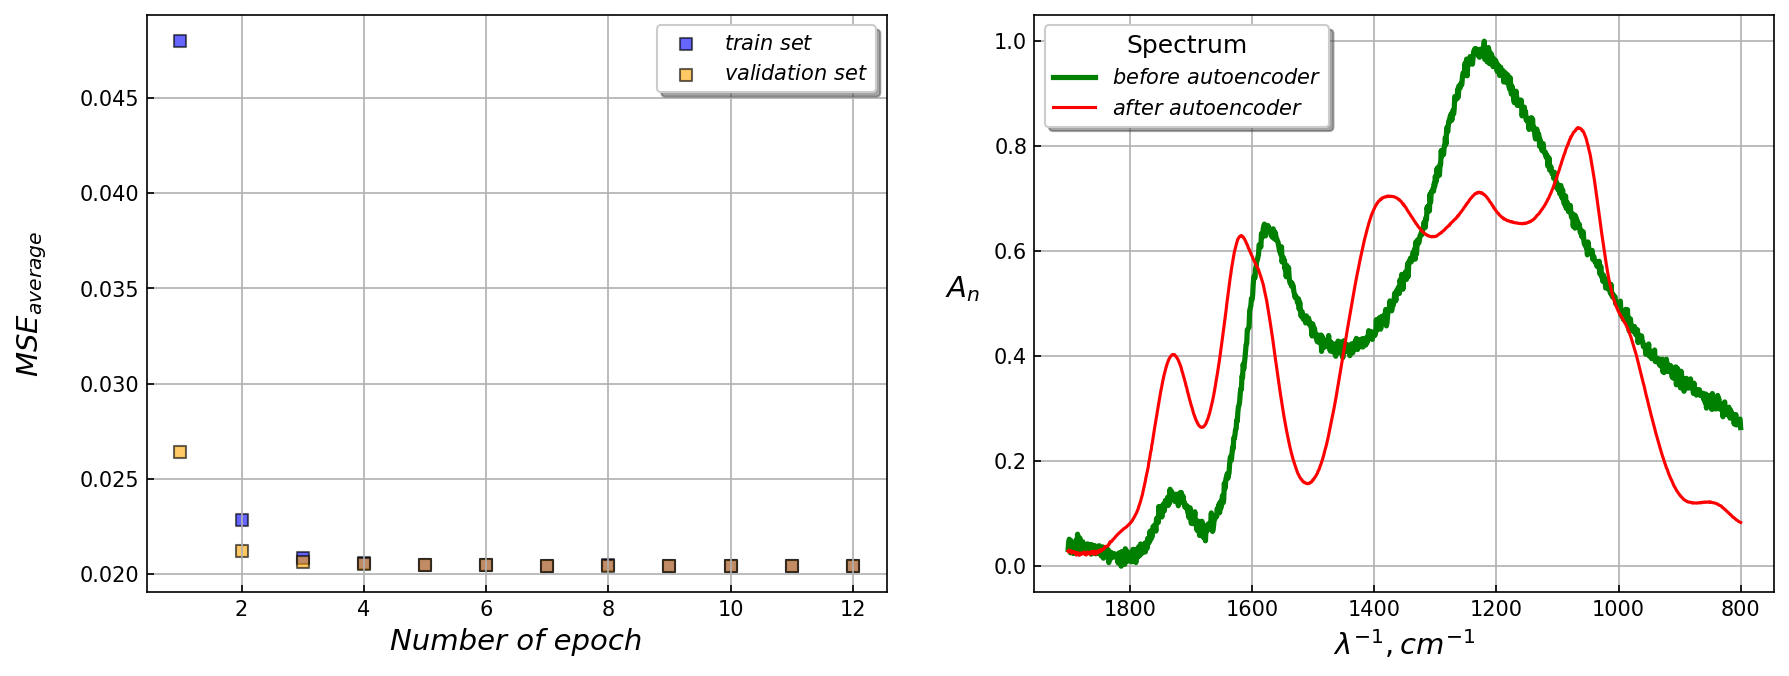

CPU times: user 2min 59s, sys: 19 s, total: 3min 18s
Wall time: 2min 51s


In [155]:
%%time

train(model=autoencoder,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=64,
      stop_criteria=1e-4
     )

**Выводы:**
* Линейные слои оптимизируют веса так, чтобы получался спектр, минимизирующий лосс в среднем для всех объектов;
* Эмбеддинги для разных обрахцов будут совпадать;
* Данная модель не подходит для дальнейшей кластеризации.

## Модель на основе сверточных слоев

### Энкодер

In [156]:
def encoder_block(in_channels,
                  out_channels,
                  kernel_size,
                  padding):
    block = nn.Sequential(
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.Sigmoid(),
        nn.MaxPool1d(kernel_size=2)
    )
    return block

### Декодер

In [157]:
def decoder_block(in_channels,
                  out_channels,
                  kernel_size,
                  padding):
    block = nn.Sequential(
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.Sigmoid(),
        nn.Upsample(scale_factor=2, mode='linear')
    )
    return block

### Функция для создания заданной архитектуры

In [158]:
def make_model(obj_length,
               depth_factor=1):
    encoder_components = []
    decoder_components = []
    obj_length_lst = [obj_length]
    
    for i in range(0, depth_factor, 1):
        in_channels = 2 ** (i)
        out_channels = 2 ** (i + 1)
        
        if obj_length_lst[0] % 2 != 0:
            lin_layer = nn.Linear(obj_length, obj_length - 1)
            encoder_components.append(lin_layer)
            continue
        
        if obj_length % 2 == 0:
            kernel_size = 3
            padding = 1
        else:
            kernel_size = 2
            padding = 0
            
        encoder_comp = encoder_block(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     padding=padding)
        
        encoder_components.append(encoder_comp)
        
        obj_length = obj_length // 2
        obj_length_lst.append(obj_length)
    
    for i in range(depth_factor, 0, -1):
        in_channels = 2 ** (i)
        out_channels = 2 ** (i - 1)
        
        kernel_size = 3
        padding = 1
            
        decoder_comp = decoder_block(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     padding=padding)
        
        decoder_components.append(decoder_comp)

        obj_length = obj_length * 2
        
        if i == 1:
            if obj_length != obj_length_lst[0]:
                lin_layer = nn.Linear(obj_length, obj_length_lst[0])
                decoder_components.append(lin_layer)
                
    encoder_part = nn.Sequential(*encoder_components)
    decoder_part = nn.Sequential(*decoder_components)
    
    return encoder_part, decoder_part

### Архитектура в общем виде

In [159]:
class Autoencoder(nn.Module):
    def __init__(self, obj_length, depth_factor):
        super().__init__()
        
        encoder, decoder = make_model(obj_length=obj_length,
                                      depth_factor=depth_factor)
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

### Обучение моделей разной глубины

In [160]:
# Размер одного входящего объекта (спектра), эмбеддинг которого нужно получить

one_obj_length = 0

for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = np.array(inputs)
    one_obj_length = inputs.shape[-1]

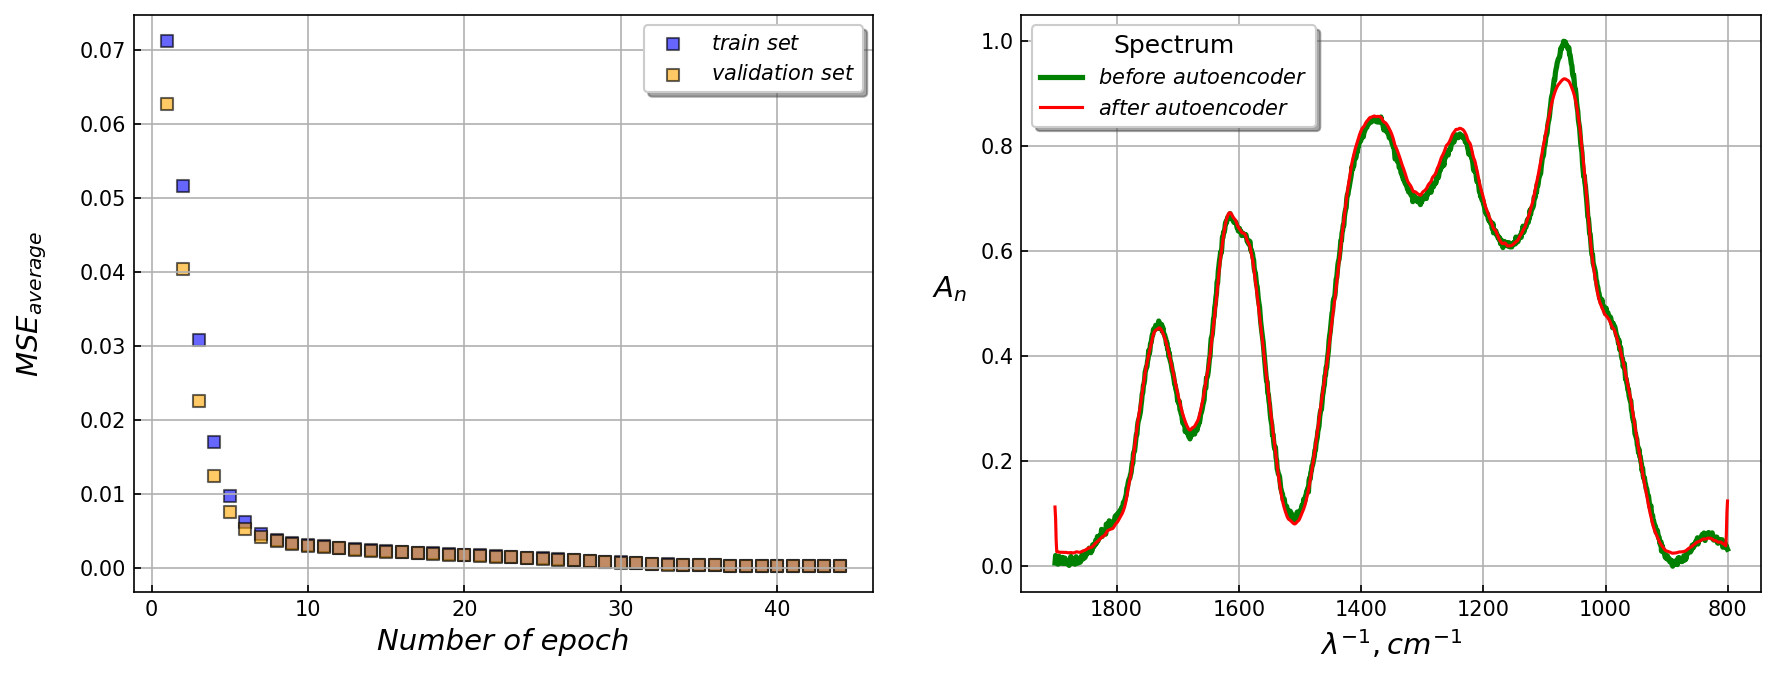

In [161]:
# depth_factor опробовали для значений из множества {1, 2, 3, 4, 5, 6, 7}

autoencoder_1 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=1)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr=1e-3)

train(model=autoencoder_1,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_1.png'
     )

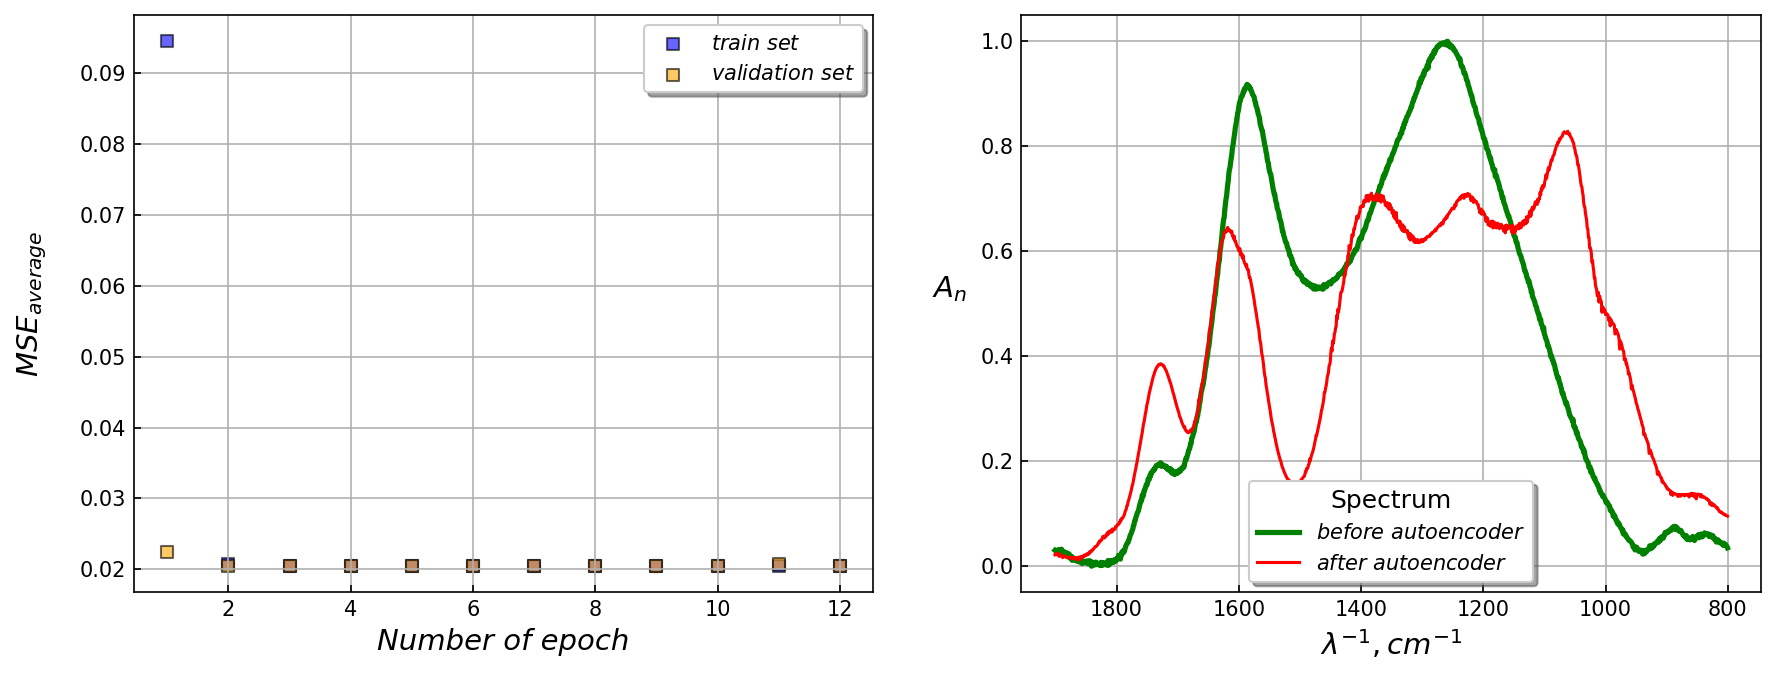

In [162]:
autoencoder_2 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=2)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr=1e-5)

train(model=autoencoder_2,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_2.png'
     )

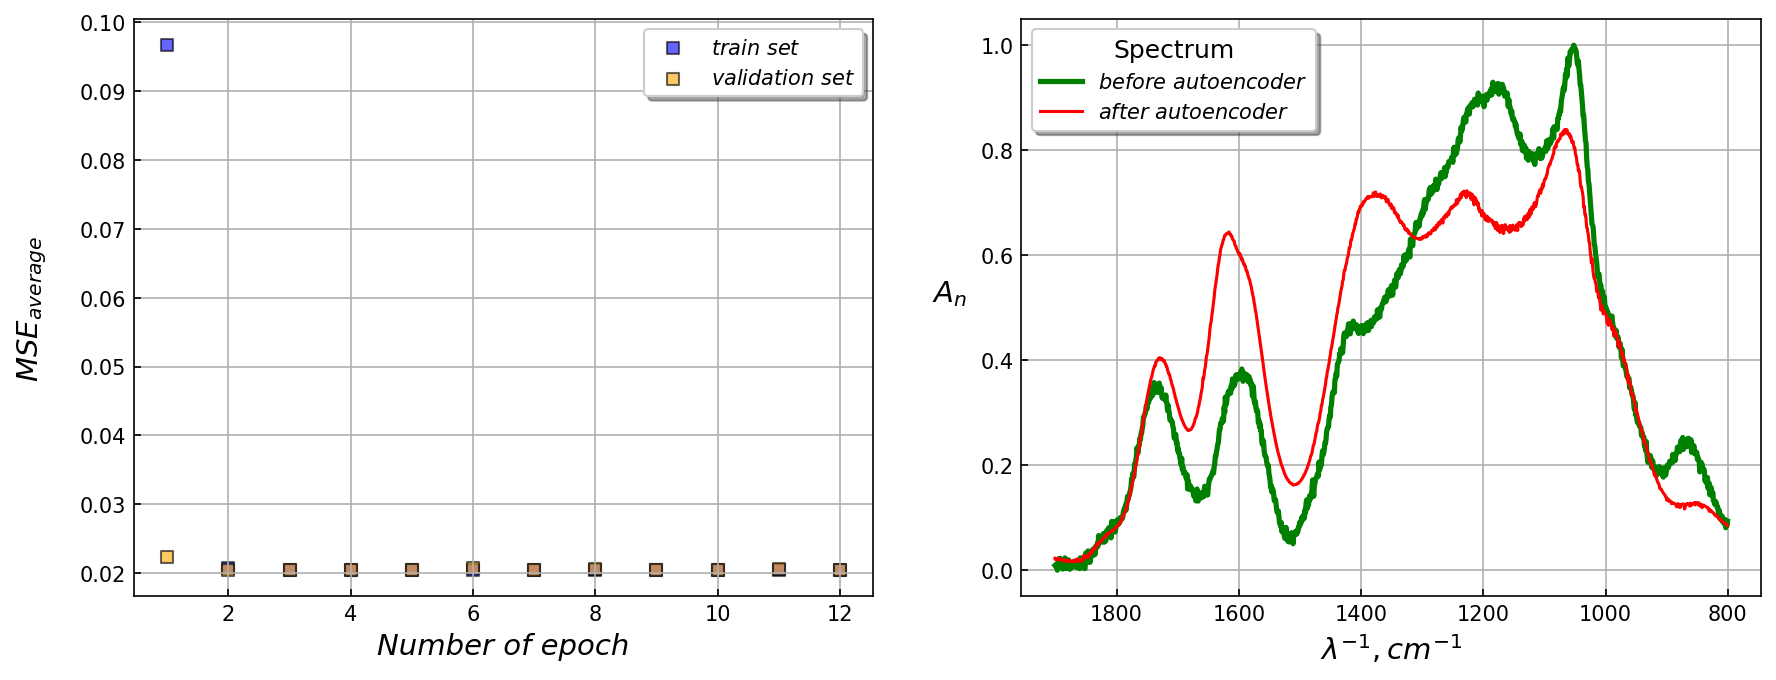

In [163]:
autoencoder_3 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=3)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_3.parameters(), lr=1e-5)

train(model=autoencoder_3,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_3.png'
     )

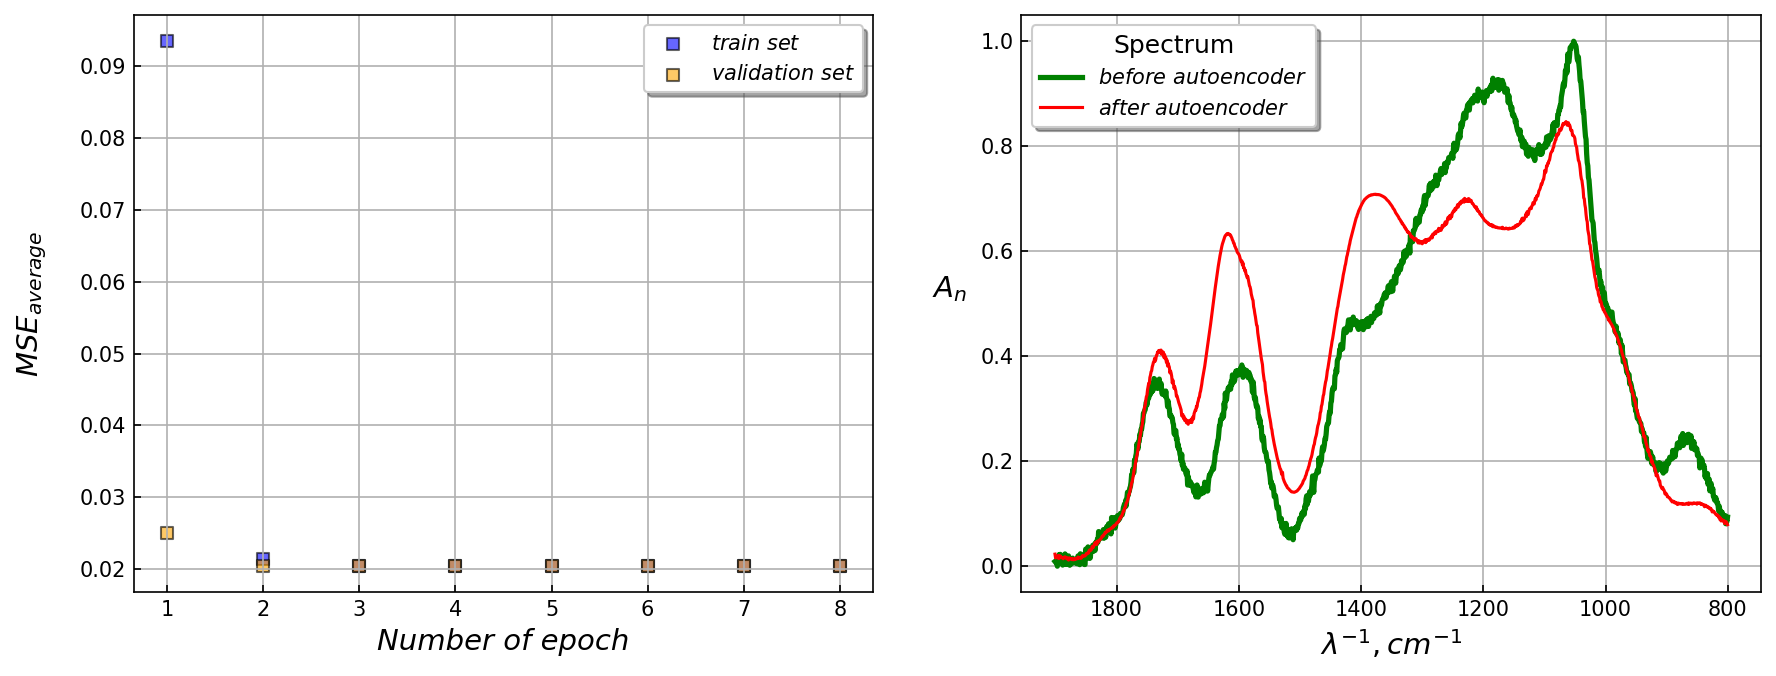

In [164]:
autoencoder_4 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=4)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_4.parameters(), lr=1e-5)

train(model=autoencoder_4,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_4.png'
     )

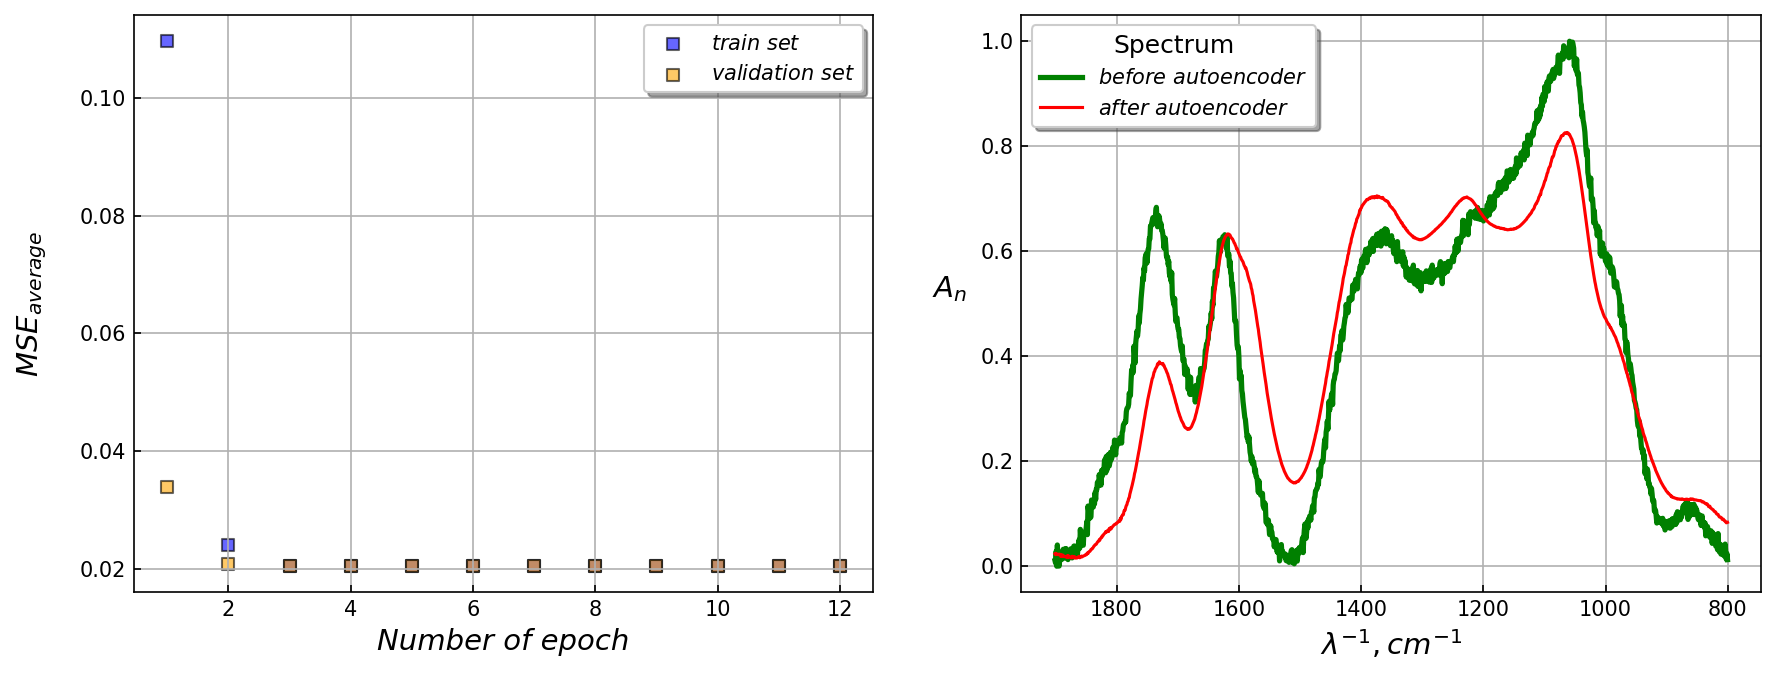

In [165]:
autoencoder_5 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=5)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_5.parameters(), lr=1e-5)

train(model=autoencoder_5,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_5.png'
     )

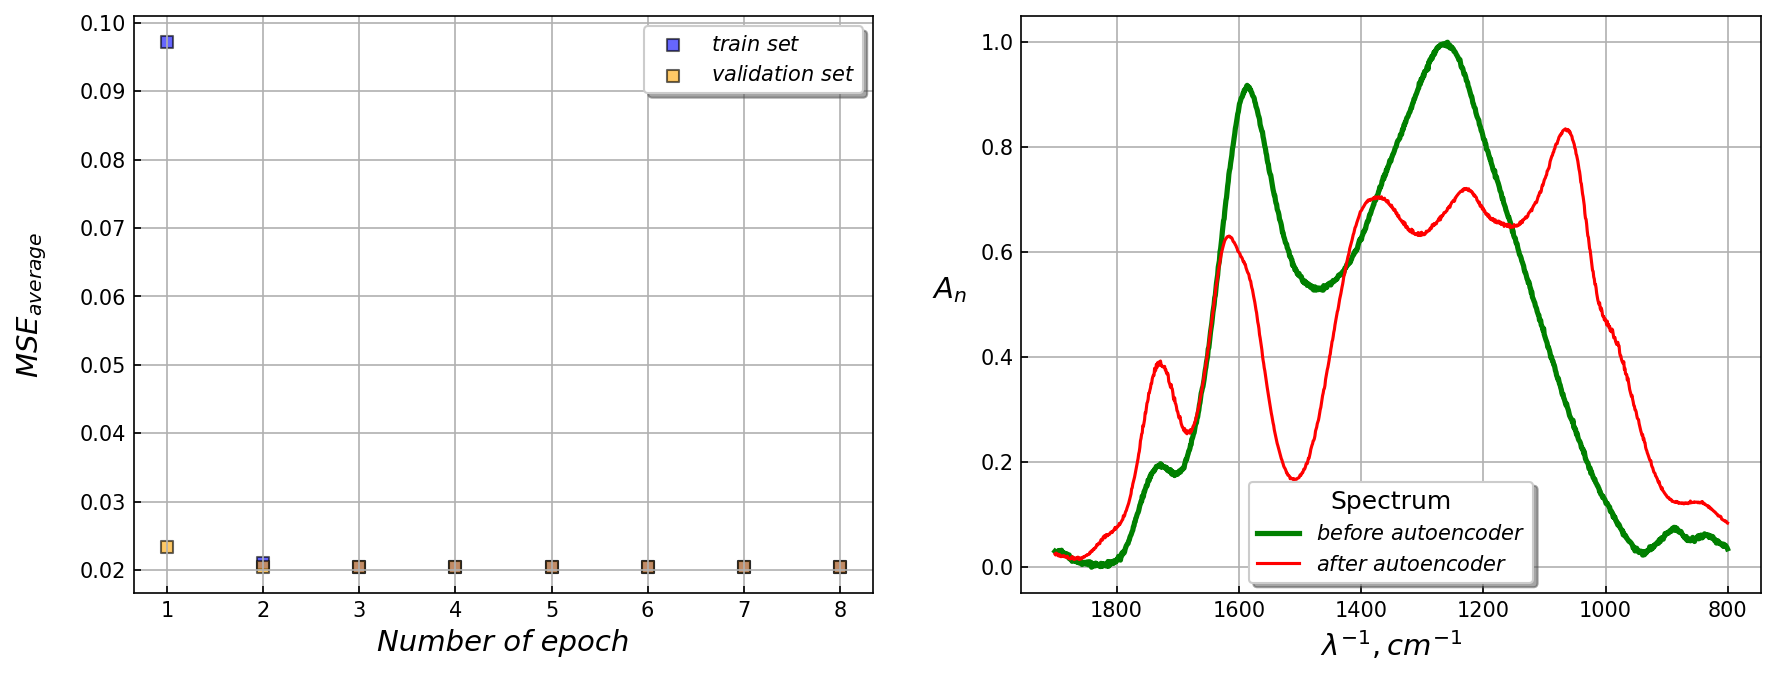

In [166]:
autoencoder_6 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=6)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_6.parameters(), lr=1e-5)

train(model=autoencoder_6,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_6.png'
     )

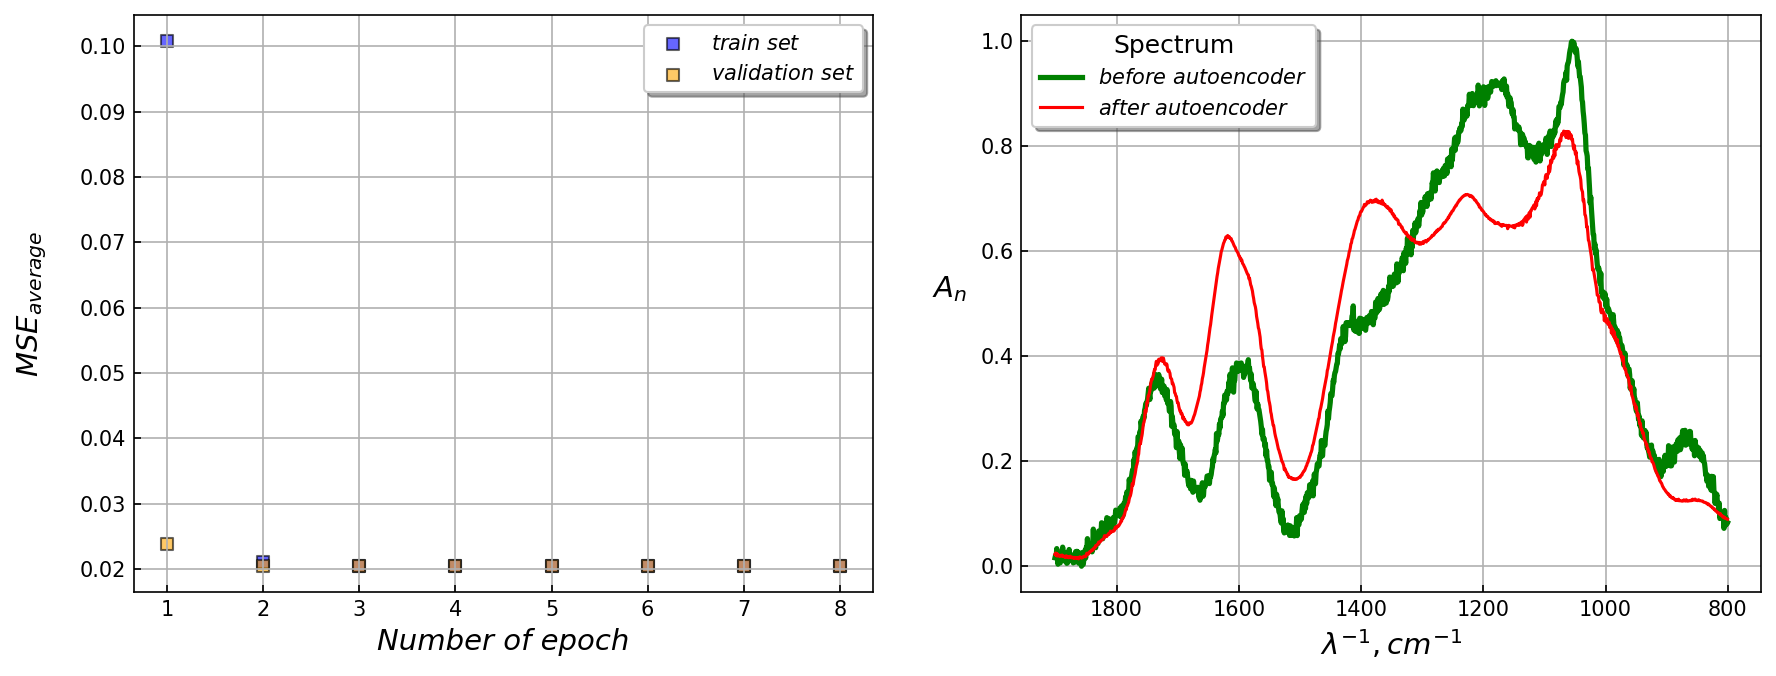

In [167]:
autoencoder_7 = Autoencoder(obj_length=one_obj_length,
                            depth_factor=7)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_7.parameters(), lr=1e-5)

train(model=autoencoder_7,
      train_loader=train_loader,
      val_loader=val_loader,
      loss_function=loss_function,
      optimizer=optimizer,
      plot_every_n_epoch=4,
      n_epochs=256,
      stop_criteria=1e-4,
      path_to_save=path_to_save + 'nn_training_depth_f_7.png'
     )

**Выводы:**
* **depth_factor** опробовали для значений из множества {1, 2, 3, 4, 5, 6, 7};
* Эмпирически показано, что повышение **depth_factor** требует понижения **learning rate**, иначе модель переобучается (нулевой лосс);
* Модели с **depth_factor > 1** практически всегда переобучаются;
* Таким образом, далее в качестве гиперпараметра выступает значение **depth_factor = 1**.

### Получение эмбеддингов и их визуализация 

In [168]:
# Функция для получения эмбеддинга

def get_embedding(model, torch_dataframe):
    _, embedding = model(torch_dataframe)
    embedding = embedding.detach().numpy()[:, 0]
    embedding_df = pd.DataFrame(embedding).iloc[:, 2:-2]  # удаляем краевые точки с шумом
    scaler = MinMaxScaler()
    embedding_df = pd.DataFrame(scaler.fit_transform(embedding_df.T).T)
    return embedding_df


# Функция для получения эмбеддинга с описанием

def get_embedding_with_descr(model, torch_dataframe):
    embedding_df = get_embedding(model=model,
                                 torch_dataframe=torch_dataframe)
    
    embedding_df.insert(loc=0, column='$Class$', value=class_lst)
    embedding_df.insert(loc=1, column='$Type$', value=short_description)
    return embedding_df

In [169]:
# получение ЭМБЕДДИНГА 1
embedding_1 = get_embedding_with_descr(model=autoencoder_1,
                                       torch_dataframe=Y_torch)

embedding_2 = get_embedding_with_descr(model=autoencoder_2,
                                       torch_dataframe=Y_torch)

embedding_3 = get_embedding_with_descr(model=autoencoder_3,
                                       torch_dataframe=Y_torch)

embedding_4 = get_embedding_with_descr(model=autoencoder_4,
                                       torch_dataframe=Y_torch)

embedding_5 = get_embedding_with_descr(model=autoencoder_5,
                                       torch_dataframe=Y_torch)

embedding_6 = get_embedding_with_descr(model=autoencoder_6,
                                       torch_dataframe=Y_torch)

embedding_7 = get_embedding_with_descr(model=autoencoder_7,
                                       torch_dataframe=Y_torch)

In [170]:
all_embeddings = [embedding_1,
                  embedding_2,
                  embedding_3,
                  embedding_4,
                  embedding_5,
                  embedding_6,
                  embedding_7]

# Кластерный анализ

In [171]:
path_to_save = 'results/ftir/step3'

In [172]:
targets = class_lst.copy()
description = short_description.copy()

## Основные функции для кластеризации

In [173]:
def plot_metrics(data,
                 targets=[],
                 max_clusters=10,
                 metric='euclidean',
                 figsize=(16, 9),
                 save='n',
                 name_of_file='f',
                 style='default',
                 dpi=300):
    if targets:
        figure_templ = [['left', 'middle', 'right']]
        gridspec_kw = {'width_ratios': [1, 1, 1]}
    else:
        figure_templ = [['left', 'right']]
        gridspec_kw = {'width_ratios': [1, 1]}
    
    fig, ax = plt.subplot_mosaic(figure_templ,
                                 gridspec_kw=gridspec_kw,
                                 figsize=figsize,
                                 dpi=dpi,
                                 layout='constrained')

    inertia = []
    silhouette = []
    if targets:
        v_measure = []
    clusters_range = range(1, max_clusters)

    for k in tqdm(clusters_range):
        kmeans = KMeans(n_clusters=k,
                        init='k-means++',
                        random_state=42)

        kmeans.fit(data)
        
        # inertia
        inertia.append(kmeans.inertia_)
        
        # v-measure
        groups = kmeans.fit_predict(data)
        if targets:
            v_measure.append(v_measure_score(groups, targets))
        
        # silhouette-score
        if k >= 2:
            silhouette.append(silhouette_score(data, kmeans.labels_))
    
    max_v_measure = round(max(v_measure), 3)
    mean_v_measure = round(np.mean(v_measure), 4)


    # Inertia Plot
    ax['left'].grid(True)
    ax['left'].tick_params(direction='in')
    ax['left'].set_title(f'Elbow method',
                         fontname='DejaVu Sans',
                         fontsize=20,
                         fontstyle='italic',
                         fontweight='heavy')
    ax['left'].plot(clusters_range,
                    inertia,
                    '-o',
                    linewidth=2.0,
                    color='orange')
    ax['left'].set_xlabel('$Number$ $of$ $clusters$',
                          fontname='DejaVu Sans',
                          fontsize=16)
    ax['left'].set_ylabel('$WCSS$',
                          fontname='DejaVu Sans',
                          fontsize=16)

    # V-measure Plot
    if targets:
        ax['middle'].grid(True)
        ax['middle'].tick_params(direction='in')
        ax['middle'].set_title(f'V-measure',
                               fontname='DejaVu Sans',
                               fontsize=20,
                               fontstyle='italic',
                               fontweight='heavy')
        ax['middle'].plot(clusters_range,
                          v_measure,
                          '-o',
                          color='orange')
        ax['middle'].plot([], [], ' ', label='$V_{max}$' + f'= {max_v_measure}')
        ax['middle'].set_xlabel('$Number$ $of$ $clusters$',
                                fontname='DejaVu Sans',
                                fontsize=16)
        ax['middle'].set_ylabel('$V$',
                                fontname='DejaVu Sans',
                                fontsize=16)
        ax['middle'].legend(fancybox=True,
                            shadow=True,
                            loc='best',
                            prop={'size': 20})
    else:
        pass
    
    # Silhouette-score Plot
    ax['right'].grid(True)
    ax['right'].tick_params(direction='in')
    ax['right'].set_title(f'Silhouette score',
                          fontname='DejaVu Sans',
                          fontsize=20,
                          fontstyle='italic',
                          fontweight='heavy')
    ax['right'].plot(clusters_range[1:],
                     silhouette,
                     '-o',
                     linewidth=2.0,
                     color='orange')
    ax['right'].set_xlabel('$Number$ $of$ $clusters$',
                           fontname='DejaVu Sans',
                           fontsize=16)
    ax['right'].set_ylabel('$SS$',
                           fontname='DejaVu Sans',
                           fontsize=16)

    fig.tight_layout()
    if save in ['y', 'Y', 'yes']:
        plt.savefig(name_of_file, dpi=dpi)
    plt.show()

In [174]:
def optimal_number_of_clusters(data,
                               metric='silhouette',
                               targets=[],
                               max_n_clusters=10):
    n_metric_value_dict = {}
    
    for n_clusters in range(2, max_n_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=42)
        kmeans.fit(data)
        
        if metric == 'silhouette':
            if n_clusters >= 2:
                n_metric_value_dict[n_clusters] = silhouette_score(data, kmeans.labels_)
        elif metric == 'v-measure':
            groups = kmeans.fit_predict(data)
            n_metric_value_dict[n_clusters] = v_measure_score(groups, targets)   
    
    opt_n_clusters = sorted(n_metric_value_dict.items(), key=lambda x:x[1], reverse=True)[0][0]
    return opt_n_clusters

In [175]:
def clustering(data,
               n_clusters,
               targets=None,
               description=None):

    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',
                    random_state=42
                   )
    labels = kmeans.fit_predict(data)
    if targets and description:
        res_df = pd.DataFrame({'Description': description,
                               'Target': targets})
        res_df['Predicted_Class'] = labels
        return targets
    elif targets:
        res_df = pd.DataFrame({'Target': targets})
        res_df['Predicted_Class'] = labels
        return targets
    elif description:
        res_df = pd.DataFrame({'Description': description})
        res_df['Predicted_Class'] = labels
        return targets
    else:
        return pd.DataFrame(labels)

## Метрики качества кластеризации

  0%|          | 0/9 [00:00<?, ?it/s]

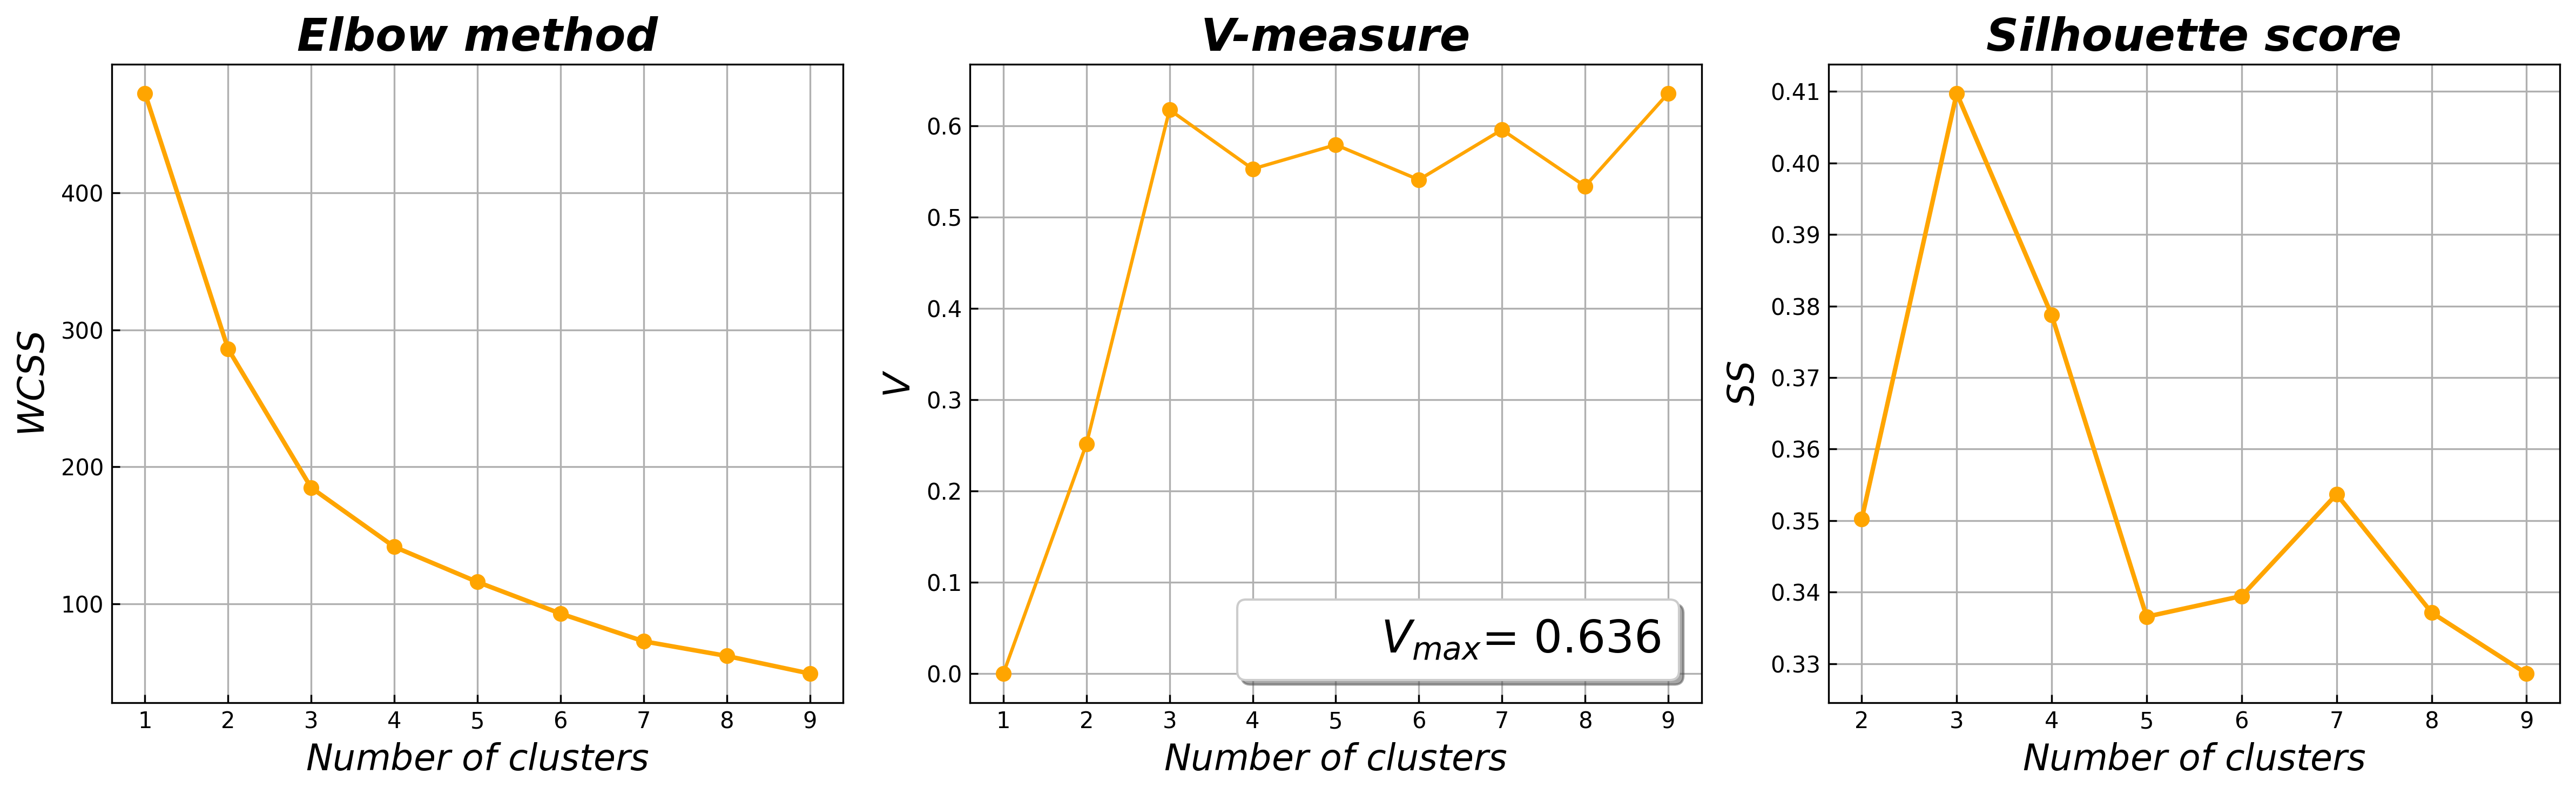

  0%|          | 0/9 [00:00<?, ?it/s]

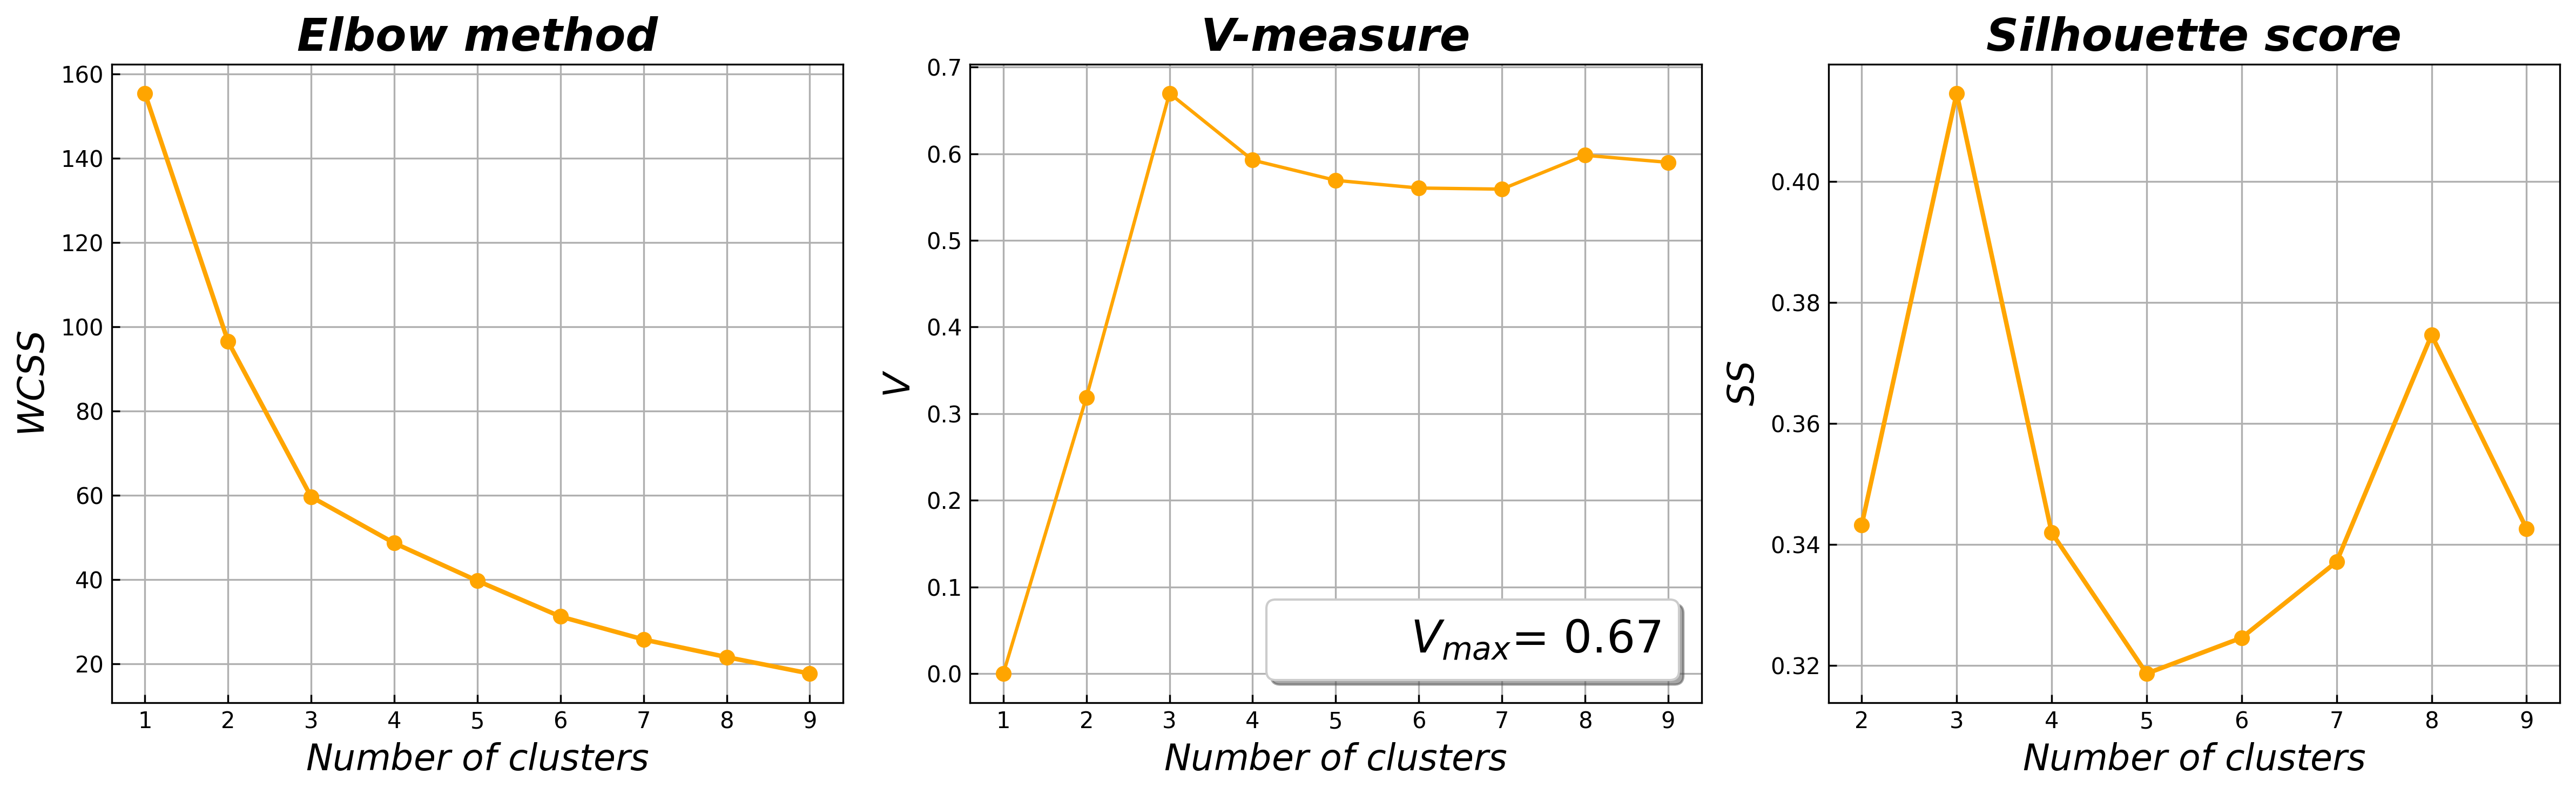

  0%|          | 0/9 [00:00<?, ?it/s]

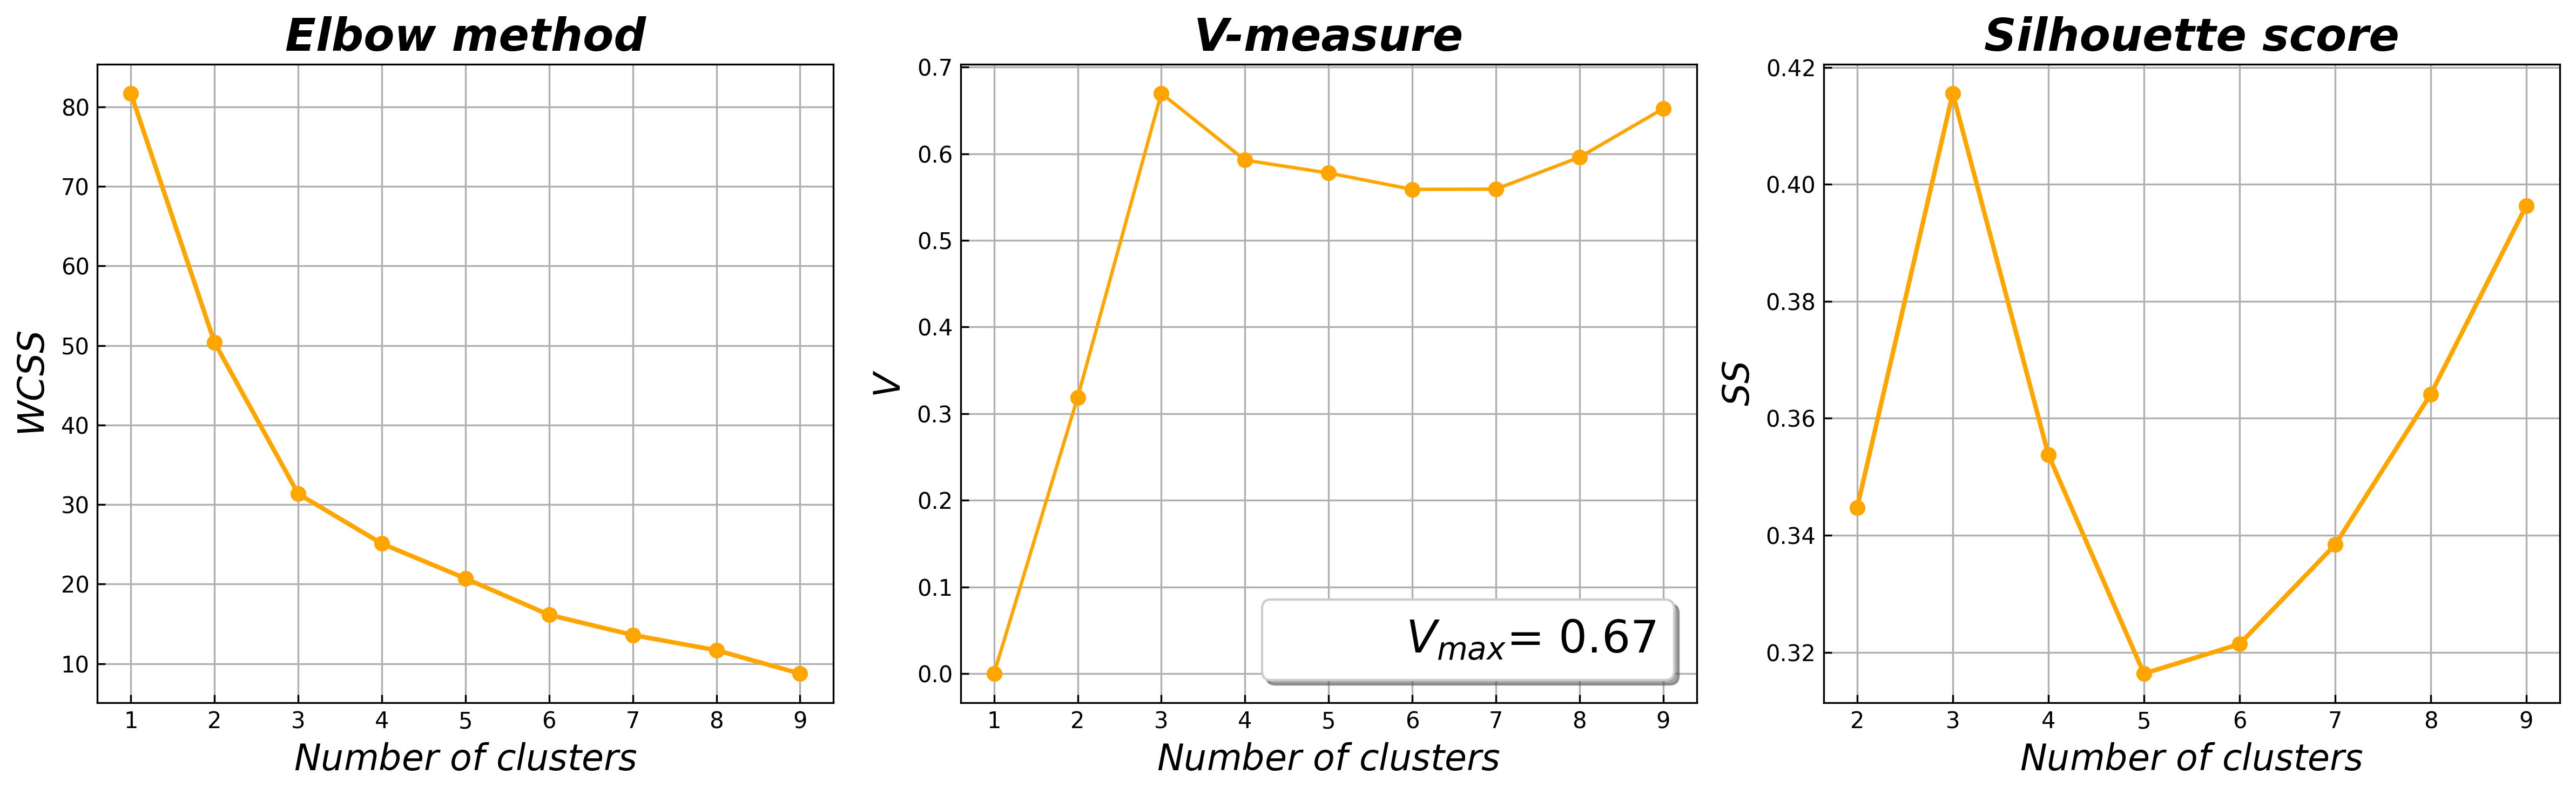

  0%|          | 0/9 [00:00<?, ?it/s]

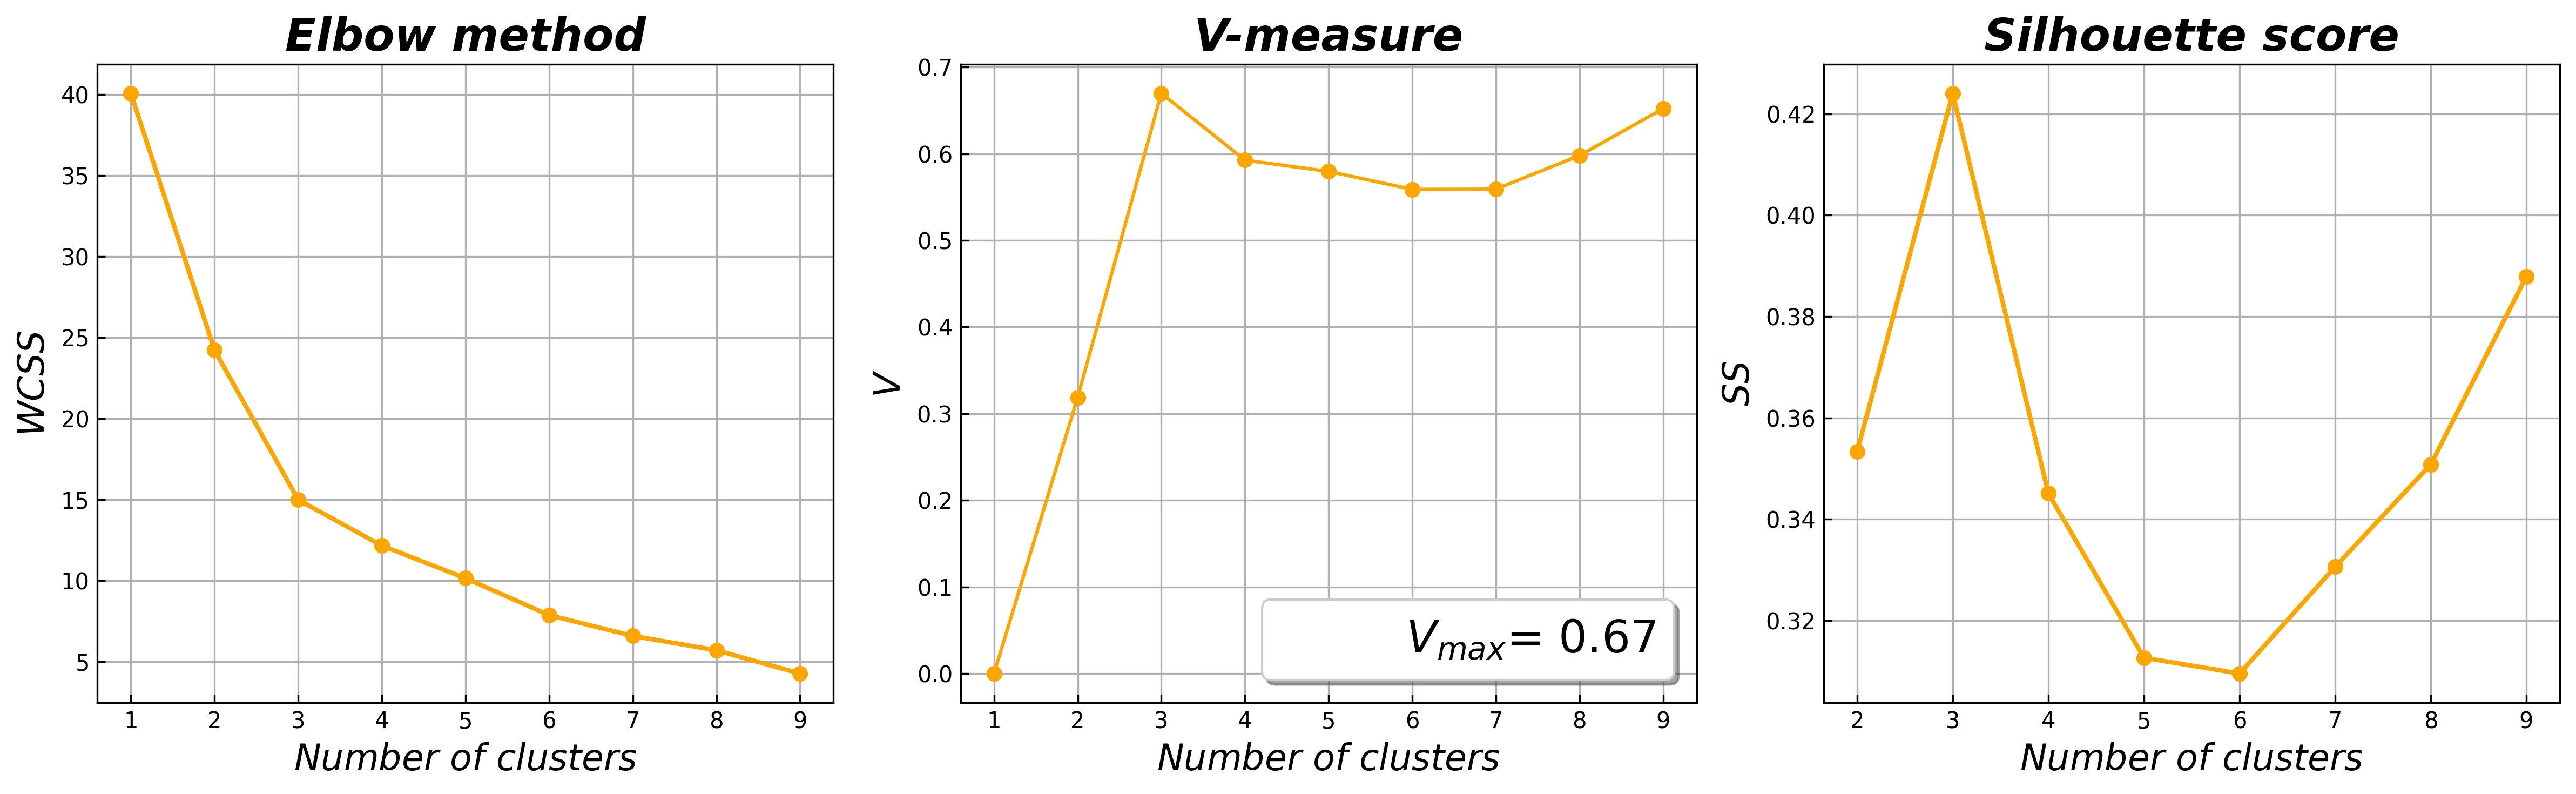

  0%|          | 0/9 [00:00<?, ?it/s]

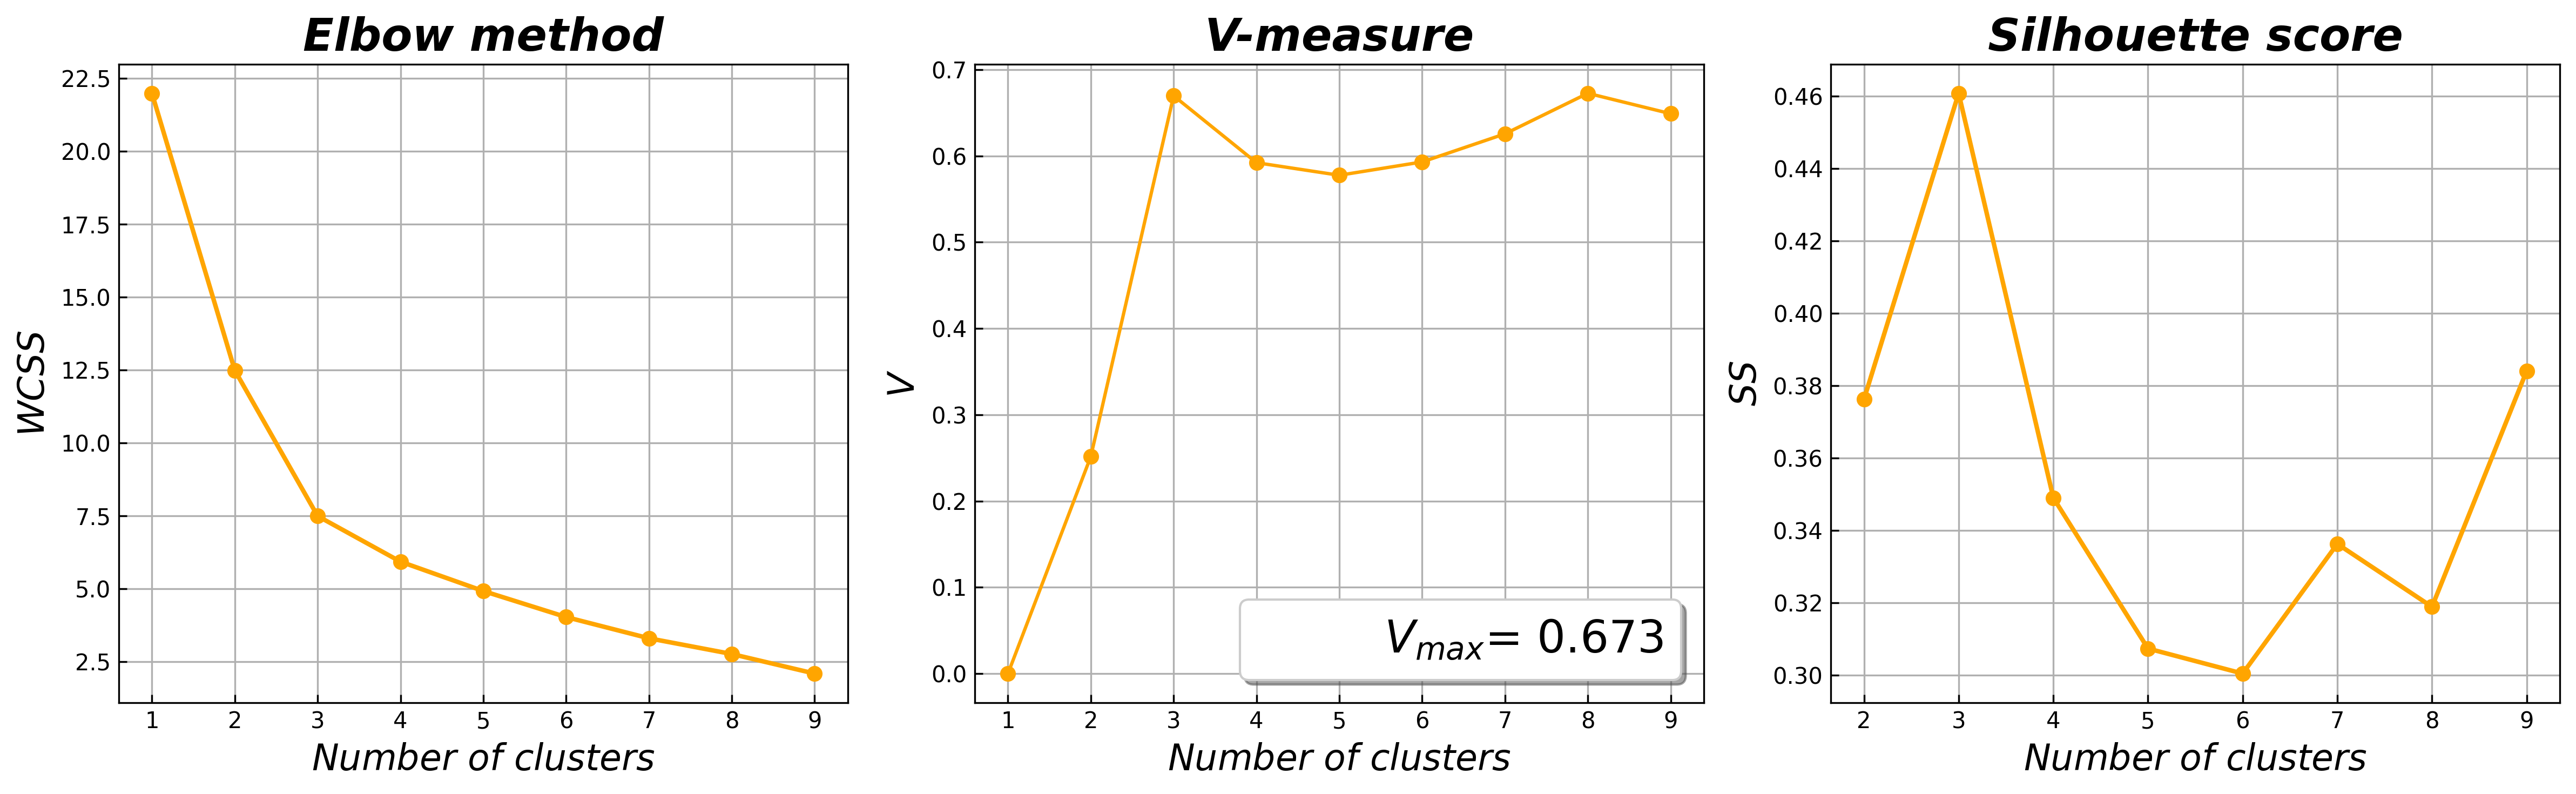

  0%|          | 0/9 [00:00<?, ?it/s]

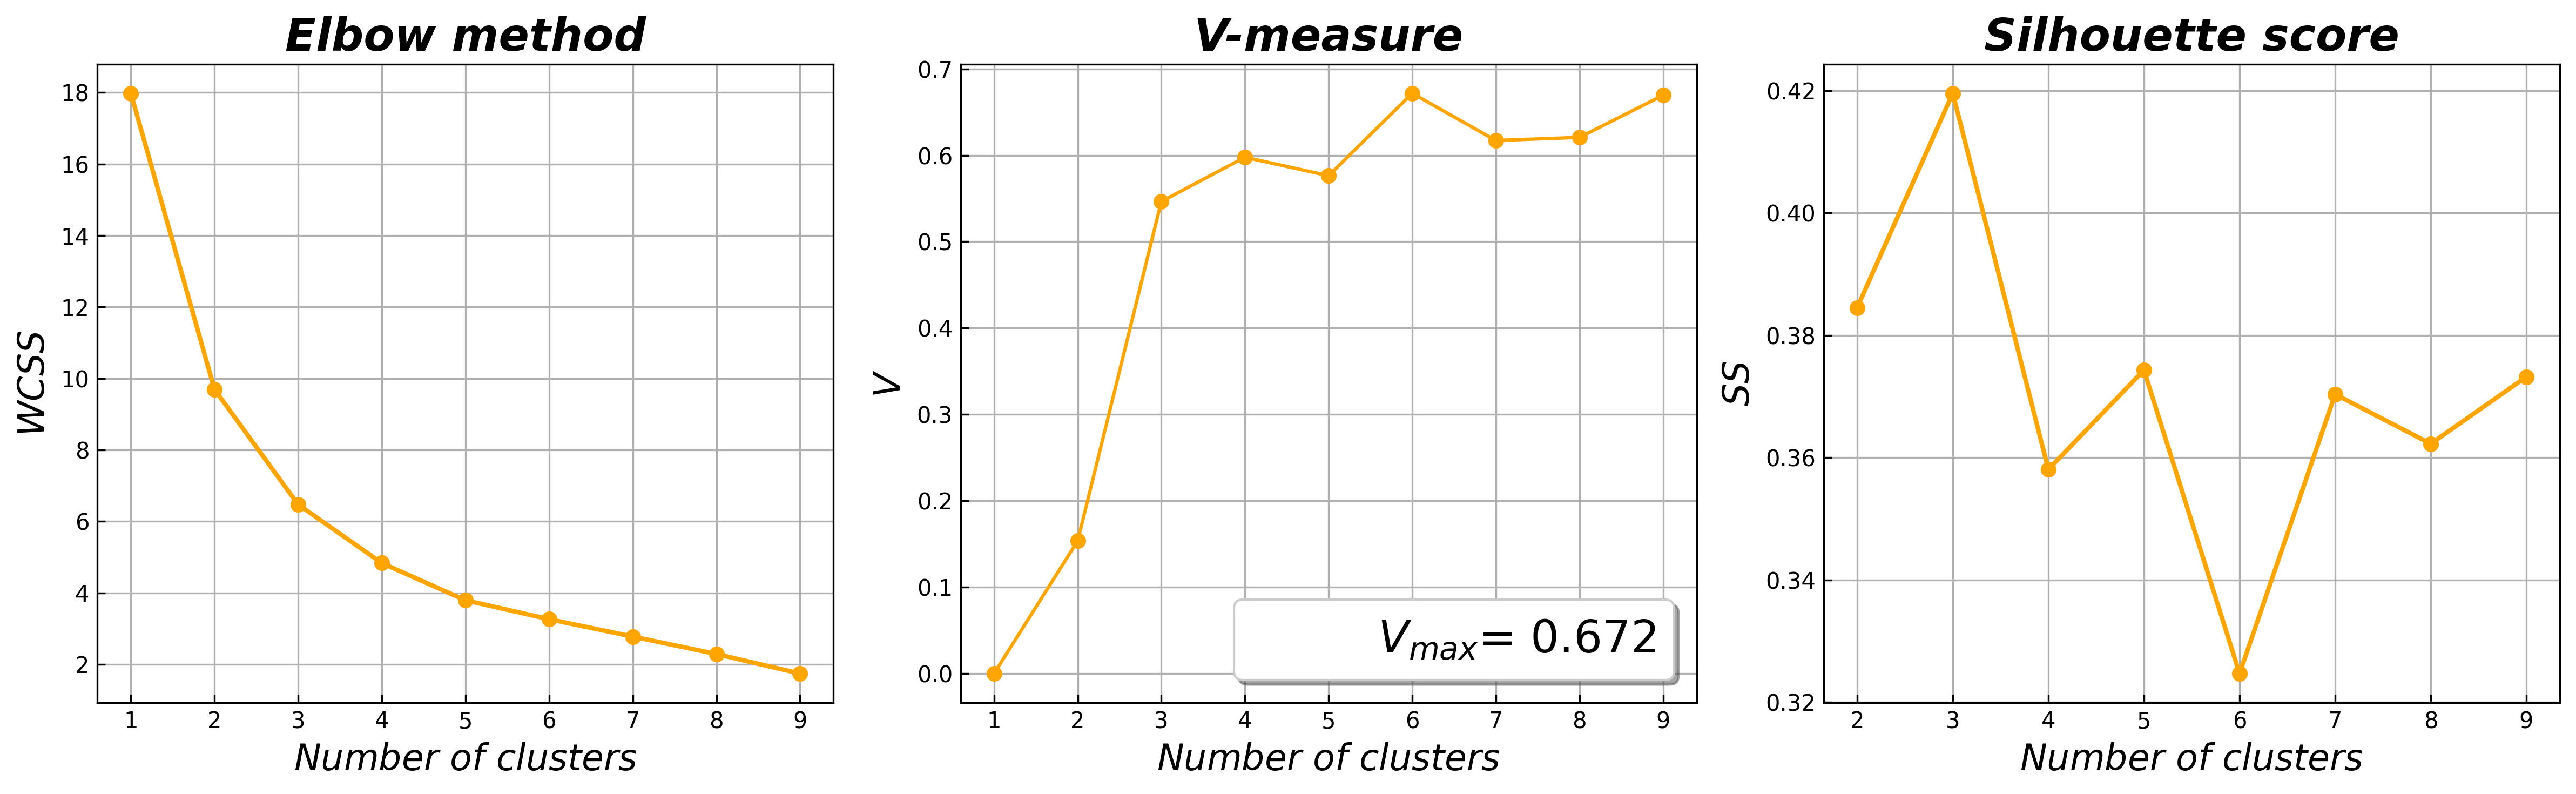

  0%|          | 0/9 [00:00<?, ?it/s]

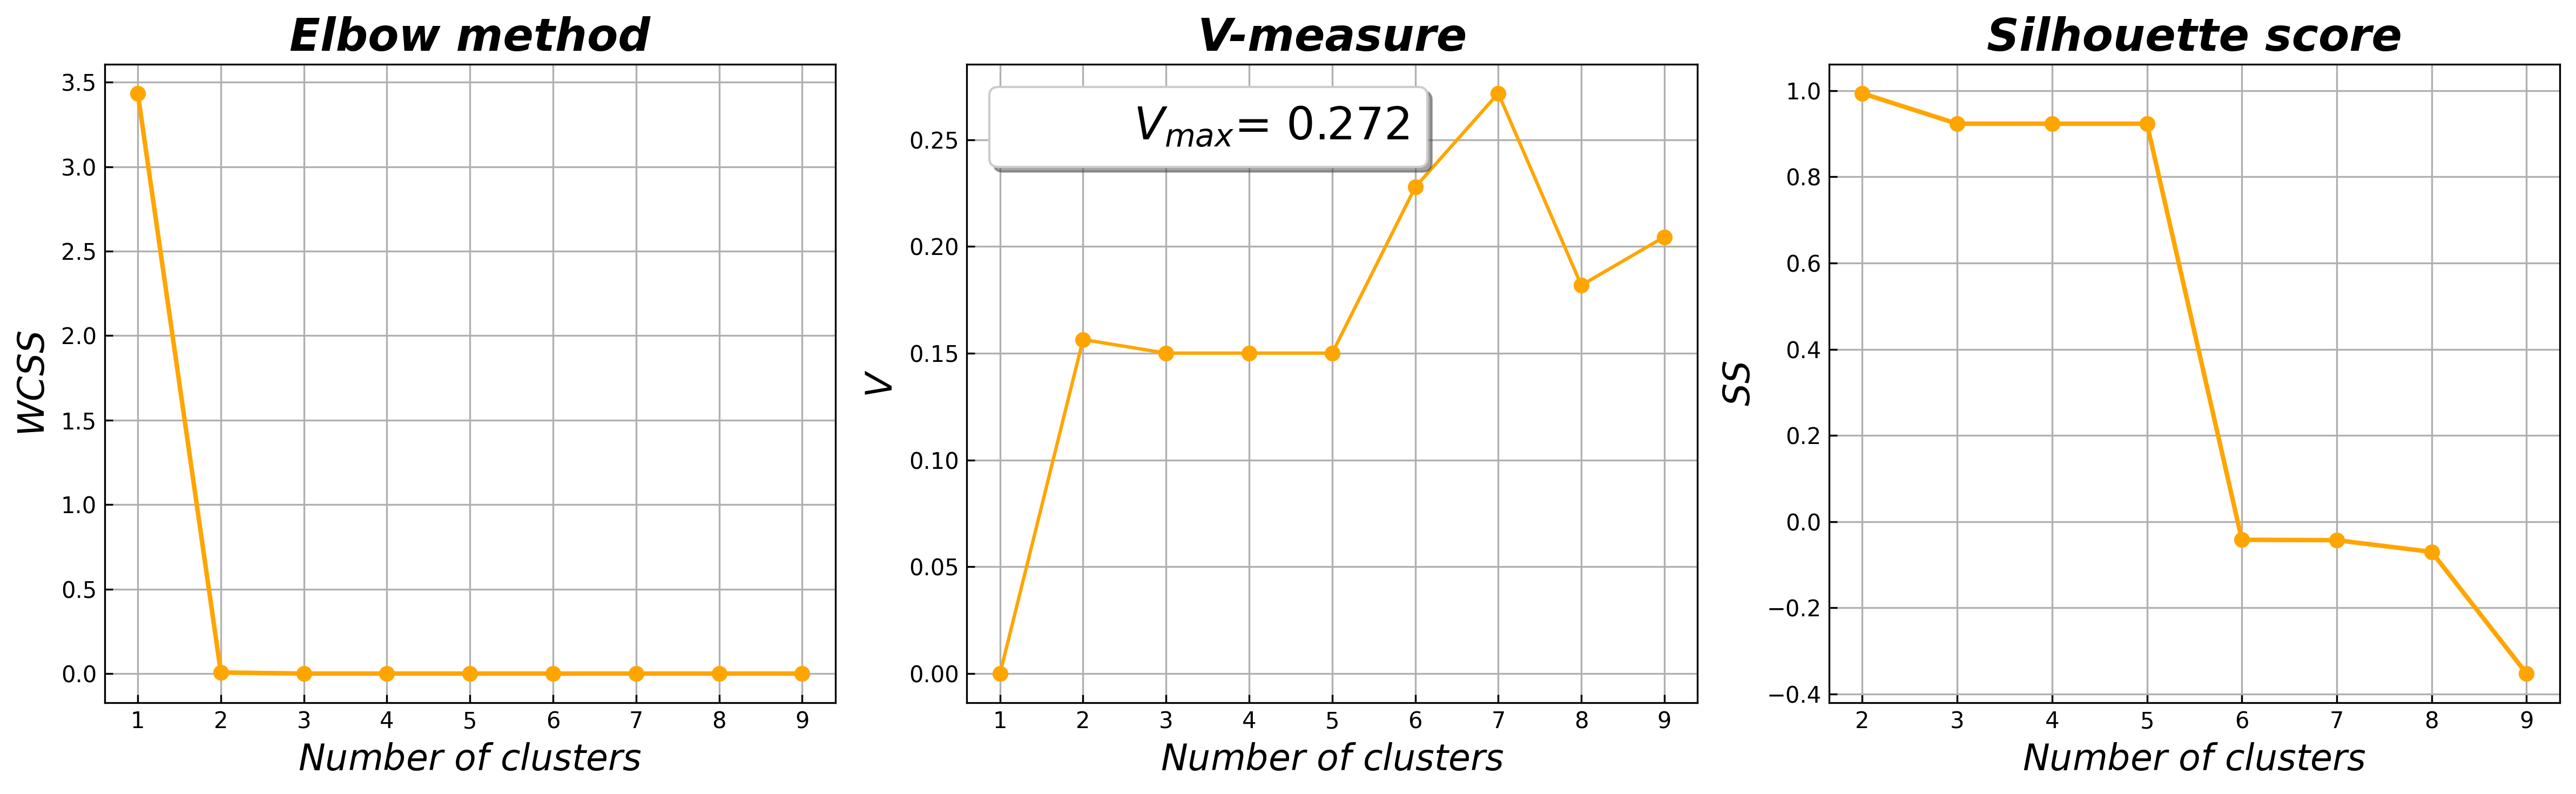

In [176]:
for embedding in all_embeddings:
    embedding = embedding.iloc[:, 2:]
    plot_metrics(data=embedding,
                  targets=targets,
                  max_clusters=10,
                  metric='euclidean',
                  save='n',
                  name_of_file='f',
                  style='default',
                  figsize=(16, 5),
                  dpi=300
                 )

In [177]:
clustering(data=embedding_1.iloc[:, 2:],
           n_clusters=4,
           targets=targets,
           description=description)

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]